In [52]:
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import spacy
from spacy.lang.en import English
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import Pipeline
import re 
from wordcloud import WordCloud
import nltk
import string
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, classification_report, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Cremator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# https://matplotlib.org/stable/tutorials/introductory/customizing.html 

# для темной темы jupyter
plt.rcParams.update({
    "axes.grid": True,
    "grid.color": "1",
    "grid.linestyle": "--",
    "xtick.bottom": True,
    "ytick.left": True,
    "figure.facecolor": "#111111",
    "axes.facecolor": "#212121",
    "text.color": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "axes.labelcolor": "white",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.edgecolor": "white",
    "grid.alpha": .3,
    "figure.figsize": [10, 5]
})

# для темной темы colab
# sns.set_style({"figure.facecolor": "#1E1E1E",
#                "axes.facecolor": "#383838"})

# <center>ДЗ 11. Класификация текста</center>

## 1. Analyze

In [3]:
df = pd.read_csv('IMDB Dataset.csv', delimiter=',')
df['sentiment'].replace({'positive' : 1 , 'negative' : 0} , inplace = True)
pd.set_option('display.max_colwidth', 180)
df.head(20)

,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first ...",1
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of rea...",1
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic...",1
3,Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be ...",1
5,"Probably my all-time favorite movie, a story of selflessness, sacrifice and dedication to a noble cause, but it's not preachy or boring. It just never gets old, despite my havi...",1
6,I sure would like to see a resurrection of a up dated Seahunt series with the tech they have today it would bring back the kid excitement in me.I grew up on black and white TV ...,1
7,"This show was an amazing, fresh & innovative idea in the 70's when it first aired. The first 7 or 8 years were brilliant, but things dropped off after that. By 1990, the show w...",0
8,Encouraged by the positive comments about this film on here I was looking forward to watching this film. Bad mistake. I've seen 950+ films and this is truly one of the worst of...,0
9,"If you like original gut wrenching laughter you will like this movie. If you are young or old then you will love this movie, hell even my mom liked it.<br /><br />Great Camp!!!",1


In [4]:
print(df.shape)
print(df.info())

(50000, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB
None


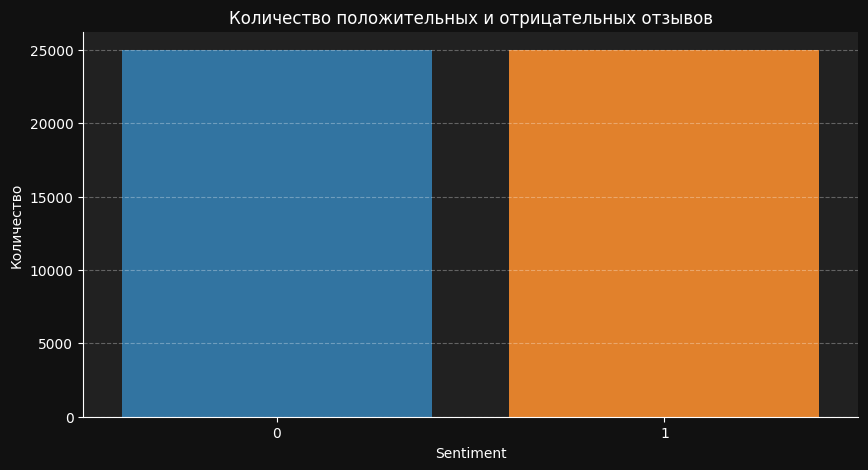

In [5]:
counts = df['sentiment'].value_counts()

sns.barplot(x=counts.index, y=counts.values)

plt.title('Количество положительных и отрицательных отзывов')
plt.xlabel('Sentiment')
plt.ylabel('Количество')
plt.show()

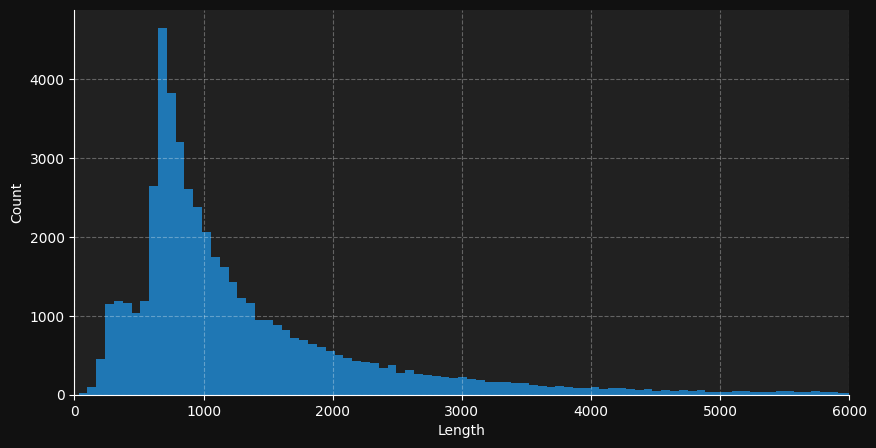

In [6]:
plt.hist(df['review'].apply(len), bins=200)
plt.xlabel('Length')
plt.ylabel('Count')
plt.xlim([0, 6000])
plt.show()

## 2. Preprocessing

1. Removing HTML Tags

In [7]:
def clean_html(text):
    clean = re.compile('<.*?>')
    return re.sub(clean , "", text)

In [8]:
df['review'] = df['review'].apply(clean_html)

2. Lowercasing

In [9]:
def convert_lower(text):
    return text.lower()

In [10]:
df['review'] = df['review'].apply(convert_lower)

3. Removing URLs

In [11]:
def remove_url(text):
    re_url = re.compile('https?://\S+|www\.\S+')
    return re_url.sub('', text)

In [12]:
df['review'] = df['review'].apply(remove_url)

4. Removing Punctuations

In [13]:
def remove_punc(text):
    return text.translate(str.maketrans('', '', exclude))

In [14]:
exclude = string.punctuation
df['review'] = df['review'].apply(remove_punc)

5. Removing stop words

In [15]:
stopwords_english = stopwords.words('english')

In [16]:
def remove_stopwords(text):
    new_text = []
    for word in text.split():
        if word in stopwords_english:
            continue
        else:
            new_text.append(word)

    return ' '.join(new_text)

In [17]:
df['review'] = df['review'].apply(remove_stopwords)

6. Stemming

In [23]:
ps = PorterStemmer()
def perform_stemming(text):
    new_text = [ps.stem(word) for word in text.split()]
    return ' '.join(new_text)

In [24]:
df['review'] = df['review'].apply(perform_stemming)

In [18]:
combined_text = ' '.join(df['review'].astype(str))

In [19]:
wordcloud = WordCloud(width=4000, height=2000, background_color='white').generate(combined_text)

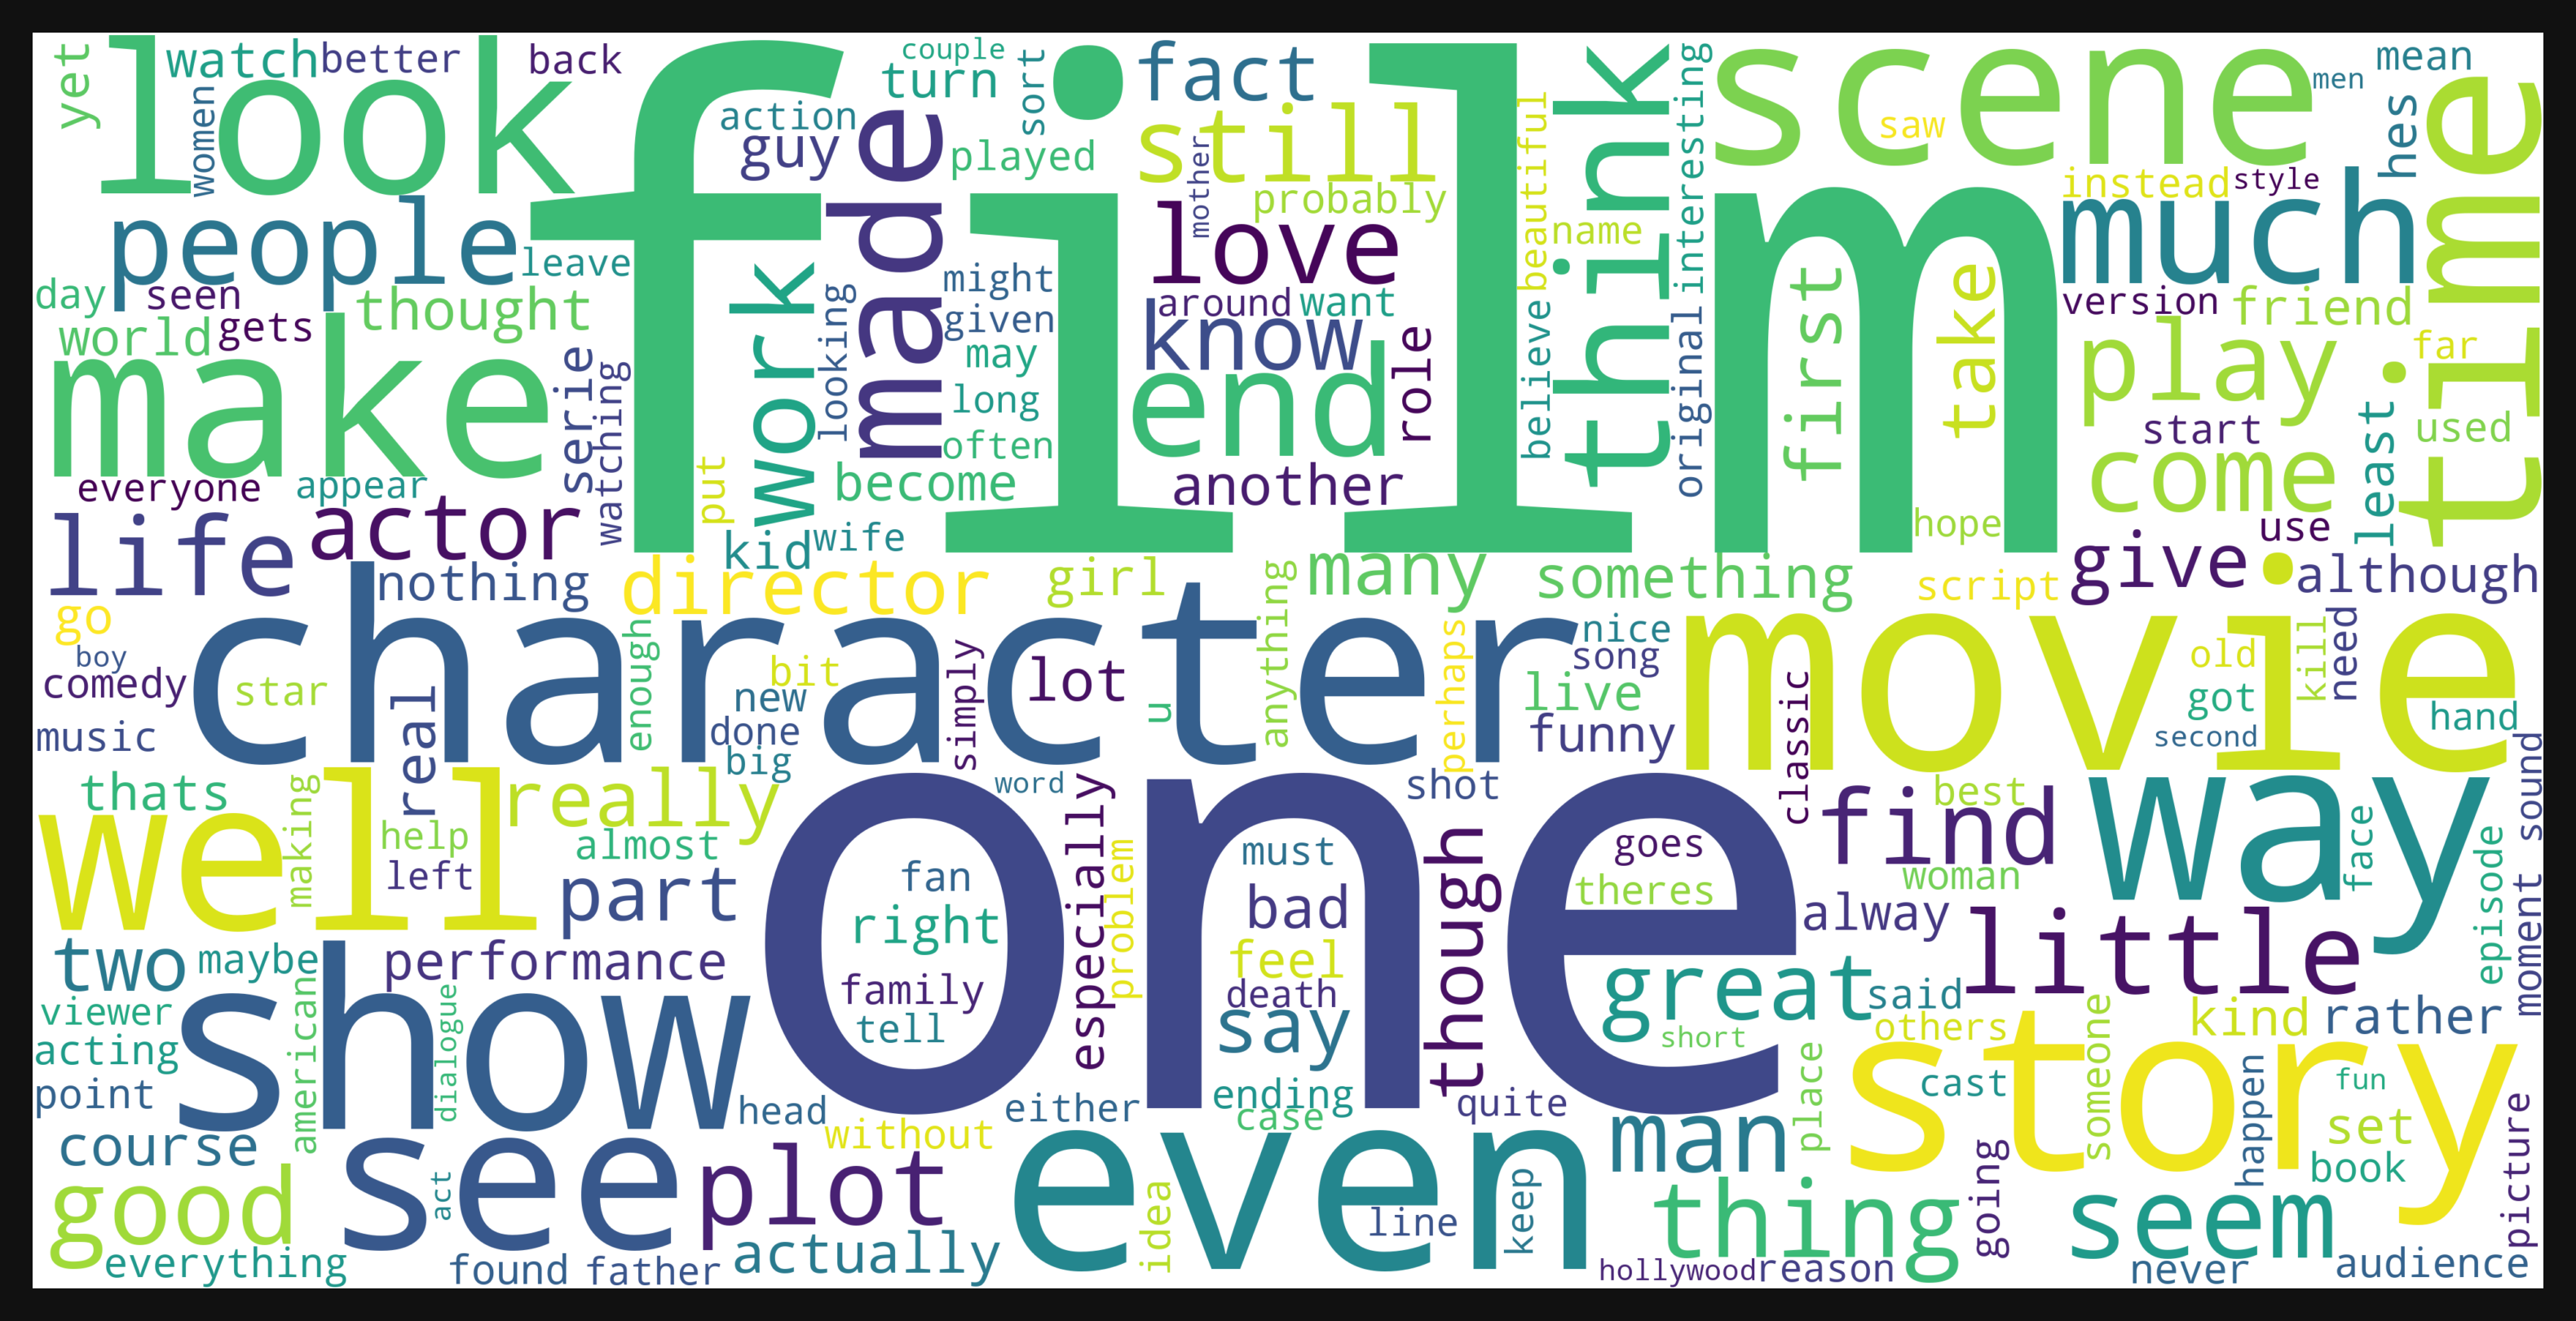

In [20]:
plt.figure(dpi=400);
plt.imshow(wordcloud, interpolation='bilinear');
plt.axis('off');
# plt.savefig('output.png', dpi=400);

In [25]:
df.head(20)

,review,sentiment
0,one review mention watch 1 oz episod youll hook right exactli happen meth first thing struck oz brutal unflinch scene violenc set right word go trust show faint heart timid sho...,1
1,wonder littl product film techniqu unassum oldtimebbc fashion give comfort sometim discomfort sens realism entir piec actor extrem well chosen michael sheen got polari voic pat...,1
2,thought wonder way spend time hot summer weekend sit air condit theater watch lightheart comedi plot simplist dialogu witti charact likabl even well bread suspect serial killer...,1
3,basic there famili littl boy jake think there zombi closet parent fight timethi movi slower soap opera suddenli jake decid becom rambo kill zombieok first your go make film mus...,0
4,petter mattei love time money visual stun film watch mr mattei offer us vivid portrait human relat movi seem tell us money power success peopl differ situat encount variat arth...,1
5,probabl alltim favorit movi stori selfless sacrific dedic nobl caus preachi bore never get old despit seen 15 time last 25 year paul luka perform bring tear eye bett davi one t...,1
6,sure would like see resurrect date seahunt seri tech today would bring back kid excit mei grew black white tv seahunt gunsmok hero everi weekyou vote comeback new sea huntw nee...,1
7,show amaz fresh innov idea 70 first air first 7 8 year brilliant thing drop 1990 show realli funni anymor continu declin complet wast time todayit truli disgrac far show fallen...,0
8,encourag posit comment film look forward watch film bad mistak ive seen 950 film truli one worst aw almost everi way edit pace storylin act soundtrack film song lame countri tu...,0
9,like origin gut wrench laughter like movi young old love movi hell even mom like itgreat camp,1


## 3. Split data

In [28]:
X = df['review']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=66, stratify=y)

## 4. Tokenization

In [32]:
nlp = spacy.load("en_core_web_sm")

unwanted_pipes = ["ner", "parser"]

def custom_tokenizer(doc):
    with nlp.disable_pipes(*unwanted_pipes):
        return [t.lemma_ for t in nlp(doc) if not t.is_stop and not t.is_space and t.pos_ in ["ADJ","NOUN","VERB"]]

In [33]:
%%time

vectorizer = CountVectorizer(tokenizer=custom_tokenizer)

X_train_bow = vectorizer.fit_transform(X_train)

X_test_bow = vectorizer.transform(X_test)

print("BoW vocabulary size:", X_train_bow.shape[1])

c:\work\python39\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


BoW vocabulary size: 82438
CPU times: total: 6min 47s
Wall time: 11min 4s


In [38]:
%%time

# Parameters to tune
grid = {"alpha": [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]}

clf = MultinomialNB()

nb_bow = GridSearchCV(clf, param_grid=grid, scoring="f1_macro", n_jobs=-1, cv=5, verbose=5)

nb_bow.fit(X_train_bow, y_train)

print("Best parameters:", nb_bow.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best parameters: {'alpha': 1.0}
CPU times: total: 172 ms
Wall time: 2.24 s


In [41]:
nb_bow_preds = nb_bow.predict(X_test_bow)

print(classification_report(y_test, nb_bow_preds, target_names=["negative","positive"]))

              precision    recall  f1-score   support

    negative       0.84      0.84      0.84      5000
    positive       0.84      0.84      0.84      5000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



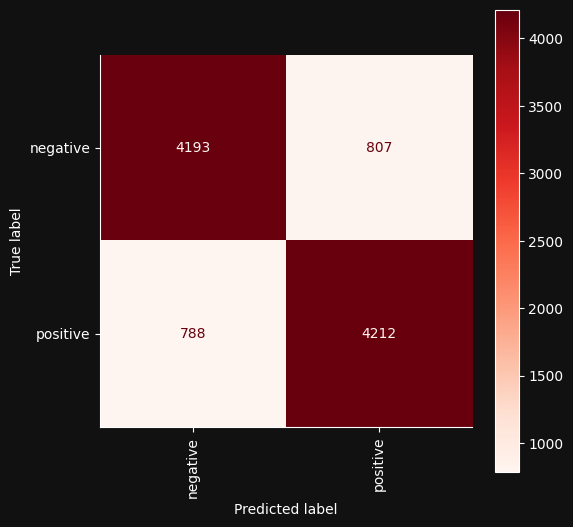

In [43]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.grid(False)

disp = ConfusionMatrixDisplay.from_estimator(nb_bow, X_test_bow, y_test, cmap="Reds", display_labels=["negative","positive"], xticks_rotation="vertical", ax=ax)

In [45]:
%%time

vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)

X_train_tfidf = vectorizer.fit_transform(X_train)

X_test_tfidf = vectorizer.transform(X_test)

print("TF-IDF vocabulary size:", X_train_tfidf.shape[1])

c:\work\python39\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


TF-IDF vocabulary size: 82438
CPU times: total: 6min 57s
Wall time: 10min 39s


In [47]:
%%time

grid = {"alpha": [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]}

clf = MultinomialNB()

nb_tfidf = GridSearchCV(clf, param_grid=grid, scoring="f1_macro", n_jobs=-1, cv=5, verbose=5)

nb_tfidf.fit(X_train_tfidf, y_train)

print("Best parameters:", nb_tfidf.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best parameters: {'alpha': 1.0}
CPU times: total: 141 ms
Wall time: 2.12 s


In [49]:
nb_tfidf_preds = nb_tfidf.predict(X_test_tfidf)

print(classification_report(y_test, nb_tfidf_preds, target_names=["negative","positive"]))

              precision    recall  f1-score   support

    negative       0.84      0.84      0.84      5000
    positive       0.84      0.84      0.84      5000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



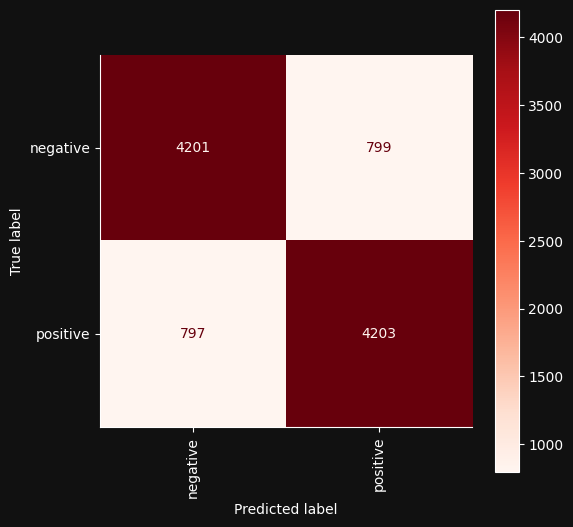

In [50]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.grid(False)

disp = ConfusionMatrixDisplay.from_estimator(nb_tfidf, X_test_tfidf, y_test, cmap="Reds", display_labels=["negative","positive"], xticks_rotation="vertical", ax=ax)

In [53]:
%%time

grid = {"penalty": ["l1","l2"], "solver": ["liblinear"], "C": [0.25, 0.5, 0.75, 1, 1.25, 1.5]}

clf = LogisticRegression()

lr_bow = GridSearchCV(clf, param_grid=grid, scoring="f1_macro", n_jobs=-1, cv=5, verbose=5)

lr_bow.fit(X_train_bow, y_train)

print("Best parameters:", lr_bow.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'C': 0.25, 'penalty': 'l2', 'solver': 'liblinear'}
CPU times: total: 2.41 s
Wall time: 44.2 s


In [55]:
lr_bow_preds = lr_bow.predict(X_test_bow)

print(classification_report(y_test, lr_bow_preds, target_names=["negative","positive"]))

              precision    recall  f1-score   support

    negative       0.86      0.84      0.85      5000
    positive       0.84      0.86      0.85      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



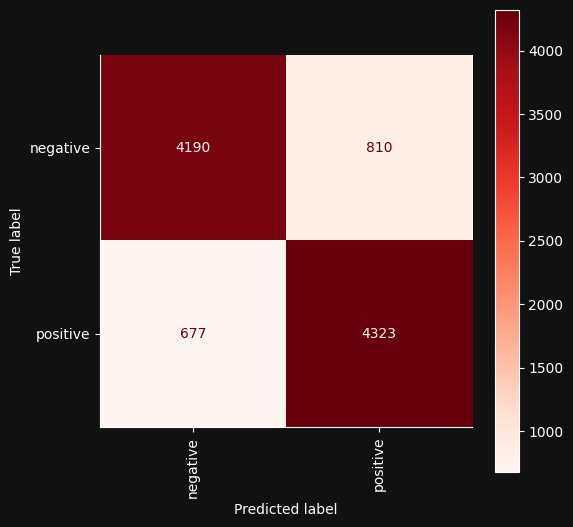

In [56]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.grid(False)

disp = ConfusionMatrixDisplay.from_estimator(lr_bow, X_test_bow, y_test, cmap="Reds", display_labels=["negative","positive"], xticks_rotation="vertical", ax=ax)

In [57]:
%%time

grid = {"penalty": ["l1","l2"], "solver": ["liblinear"], "C": [0.25, 0.5, 0.75, 1, 1.25, 1.5]}

clf = LogisticRegression()

lr_tfidf = GridSearchCV(clf, param_grid=grid, scoring="f1_macro", n_jobs=-1, cv=5, verbose=5)

lr_tfidf.fit(X_train_tfidf, y_train)

print("Best parameters:", lr_tfidf.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'C': 1.5, 'penalty': 'l2', 'solver': 'liblinear'}
CPU times: total: 688 ms
Wall time: 10.7 s


In [58]:
lr_tfidf_preds = lr_tfidf.predict(X_test_tfidf)

print(classification_report(y_test, lr_tfidf_preds, target_names=["negative","positive"]))

              precision    recall  f1-score   support

    negative       0.88      0.85      0.86      5000
    positive       0.85      0.88      0.87      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



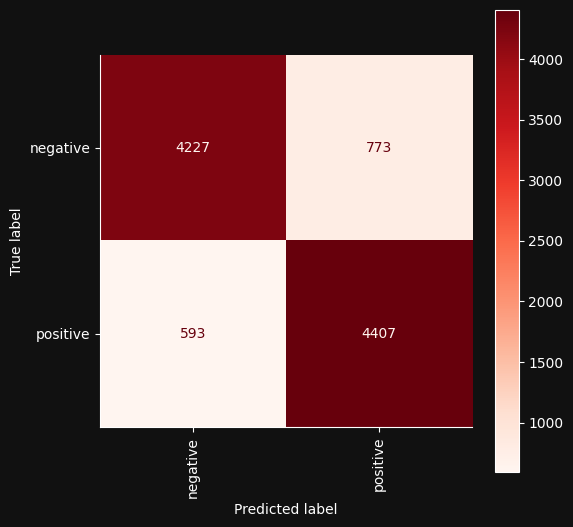

In [59]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.grid(False)

disp = ConfusionMatrixDisplay.from_estimator(lr_tfidf, X_test_tfidf, y_test, cmap="Reds", display_labels=["negative","positive"], xticks_rotation="vertical", ax=ax)